In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
import xarray as xr
from matplotlib_inline.backend_inline import set_matplotlib_formats
import seaborn as sns

import deepwaters  # noqa: F401
from deepwaters.utils import ROOT_DIR

In [ ]:
set_matplotlib_formats("retina")
plt.style.use(ROOT_DIR / "config/style_paper.mplstyle")
FIGURE_DIR = ROOT_DIR / "docs/figures/si"

In [3]:
# Load inputs and targets
inps = xr.open_zarr(ROOT_DIR / "data/processed/inputs.zarr")
tgts = xr.open_zarr(ROOT_DIR / "data/processed/targets.zarr")
recs = xr.open_zarr(ROOT_DIR / "data/processed/reconstructions.zarr")

## Plot ONI

In [4]:
oni = inps.oni
cmap = sns.color_palette()

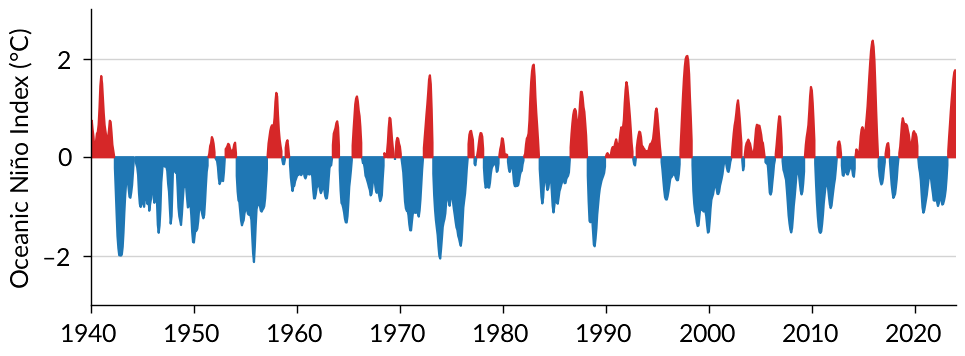

In [5]:
fig, ax = plt.subplots(figsize=(5, 2))
ax.fill_between(oni.time, y1=oni.where(oni < 0), y2=0, color=cmap[0])
ax.fill_between(oni.time, y1=oni.where(oni > 0), y2=0, color=cmap[3])
ax.set(
    xlabel=None,
    ylabel="Oceanic Niño Index (°C)",
    # ylim=(-2.5, 2.5),
    ylim=(-3, 3),
    xlim=(pd.Timestamp("1940"), pd.Timestamp("2024")),
)
ax.yaxis.grid(True)

fig.savefig(FIGURE_DIR / "oni_timeseries.pdf", backend="pgf")

## Plot Mascons and WaterGAP

In [6]:
plot_kwargs = dict(
    vmin=-400,
    vmax=400,
    coastlines=True,
    gridlines=True,
    cmap="RdYlBu",
    cbar_kwargs=dict(
        location="bottom", aspect=50, shrink=0.8, pad=0.03, label="TWS Anomaly (mm)"
    ),
    rasterized=True,
    figsize=(6, 6.5),
)

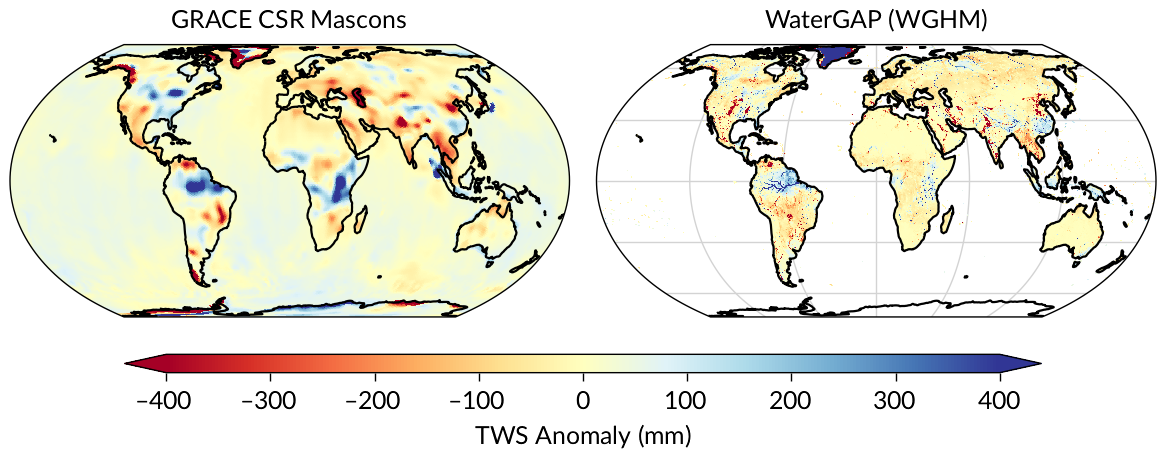

In [7]:
TIME = "2020-06-01"
gap = inps.twsa_gap.sel(time=TIME)
csr = tgts.twsa_csr.sel(time=TIME)

twsa = xr.merge([csr, gap]).to_dataarray("model")

p = twsa.dw.projplot(col="model", **plot_kwargs)
axs = p.axs.flat
axs[0].set_title("GRACE CSR Mascons")
axs[1].set_title("WaterGAP (WGHM)")

p.fig.savefig(FIGURE_DIR / f"twsa_{TIME}.pdf", backend="pgf")

## GRACE/-FO time series

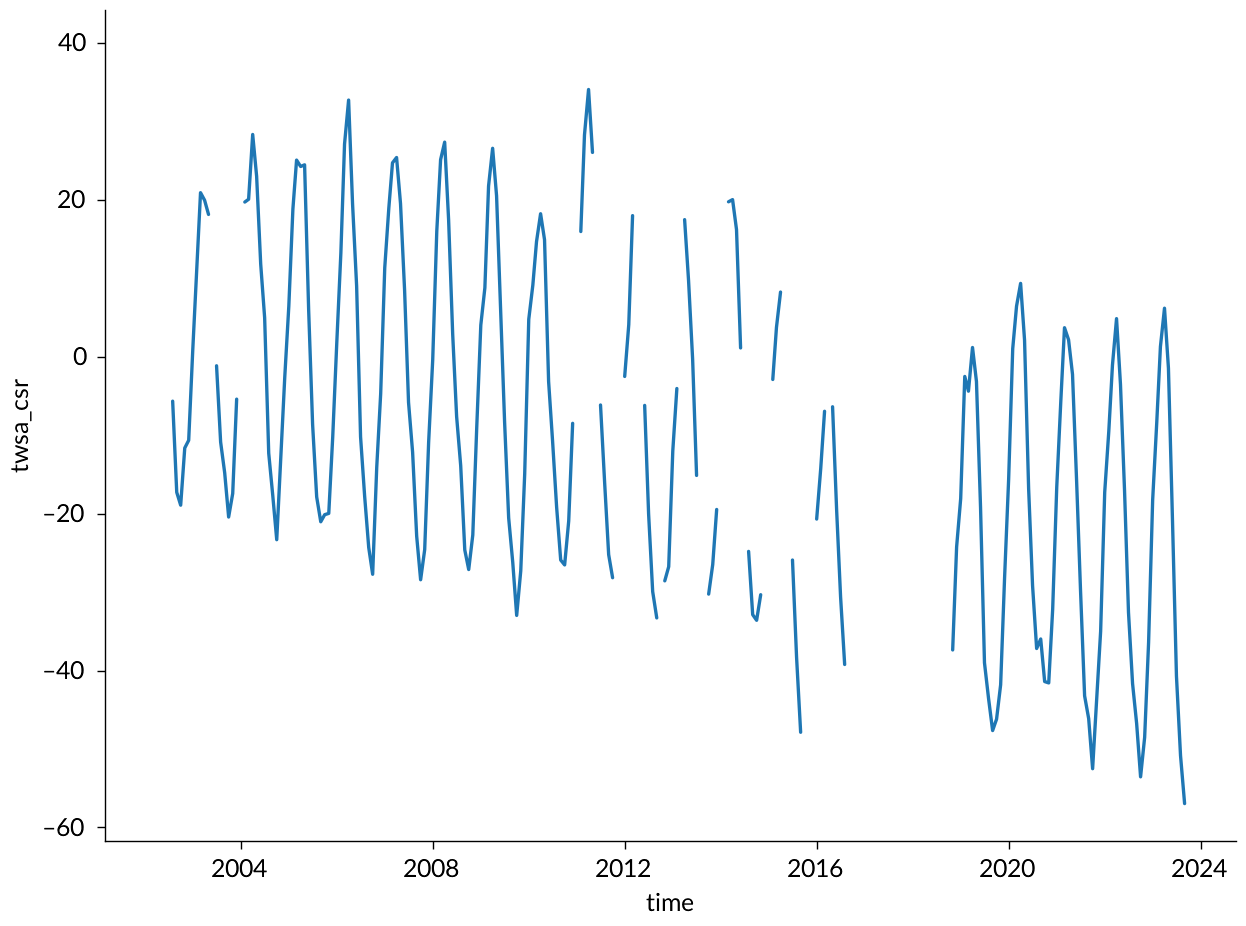

In [8]:
mask = (tgts.land_mask_jpl * tgts.land_mask_gsfc * inps.grl_ata_mask).compute()
# Use all time steps (even ones missing in GRACE data)
csr_global = (
    tgts.twsa_csr.where(mask == 1)
    .dw.weight_lat()
    .mean(["lat", "lon"])
    .chunk(time=-1)
    .compute()
)
csr_time = csr_global.get_index("time")
csr_global = csr_global.reindex(time=inps.time)
csr_global.plot()

In [9]:
# De-seasionalize
baseline = csr_global.sel(time=slice("2004", "2009"))
climatology = baseline.groupby("time.month").mean()
deseason = csr_global.groupby("time.month") - climatology
grace = deseason.sel(time=slice(None, "2017"))
gracefo = deseason.sel(time=slice("2018", None))

In [10]:
cmap = sns.color_palette()
cmap

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

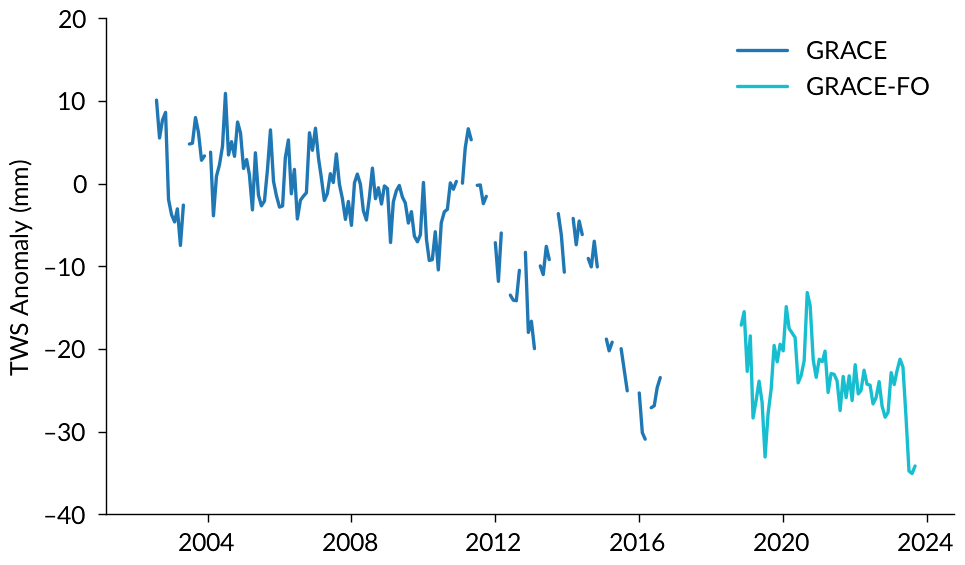

In [11]:
fig, ax = plt.subplots(figsize=(5, 3))
grace.plot(ax=ax, label="GRACE", color=cmap[0])
gracefo.plot(ax=ax, label="GRACE-FO", color=cmap[-1])
ax.set(xlabel=None, ylabel="TWS Anomaly (mm)", ylim=(-40, 20))
ax.legend()
fig.savefig(FIGURE_DIR / "grace_timeseries_deseason.pdf", backend="pgf")

## Previous reconstructions

In [12]:
recs

<xarray.Dataset> Size: 13GB
Dimensions:                 (time: 996, lat: 360, lon: 720)
Coordinates:
  * lat                     (lat) float64 3kB -89.75 -89.25 ... 89.25 89.75
  * lon                     (lon) float64 6kB -179.8 -179.2 ... 179.2 179.8
  * time                    (time) datetime64[ns] 8kB 1940-01-01 ... 2022-12-01
Data variables: (12/13)
    humphrey_gsfc_deseason  (time, lat, lon) float32 1GB dask.array<chunksize=(996, 120, 120), meta=np.ndarray>
    humphrey_gsfc_detrend   (time, lat, lon) float32 1GB dask.array<chunksize=(996, 120, 120), meta=np.ndarray>
    humphrey_jpl_deseason   (time, lat, lon) float32 1GB dask.array<chunksize=(996, 120, 120), meta=np.ndarray>
    humphrey_jpl_detrend    (time, lat, lon) float32 1GB dask.array<chunksize=(996, 120, 120), meta=np.ndarray>
    li_csr_deseason         (time, lat, lon) float32 1GB dask.array<chunksize=(996, 120, 120), meta=np.ndarray>
    li_csr_detrend          (time, lat, lon) float32 1GB dask.array<chunksize=(996, 120, 120), meta=np.ndarray>
    ...                      ...
    yin_csr_full            (time, lat, lon) float32 1GB dask.array<chunksize=(996, 120, 120), meta=np.ndarray>
    yin_csr_zerofill        (time, lat, lon) float32 1GB dask.array<chunksize=(996, 120, 120), meta=np.ndarray>
    yin_gsfc_full           (time, lat, lon) float32 1GB dask.array<chunksize=(996, 120, 120), meta=np.ndarray>
    yin_gsfc_zerofill       (time, lat, lon) float32 1GB dask.array<chunksize=(996, 120, 120), meta=np.ndarray>
    yin_jpl_full            (time, lat, lon) float32 1GB dask.array<chunksize=(996, 120, 120), meta=np.ndarray>
    yin_jpl_zerofill        (time, lat, lon) float32 1GB dask.array<chunksize=(996, 120, 120), meta=np.ndarray>

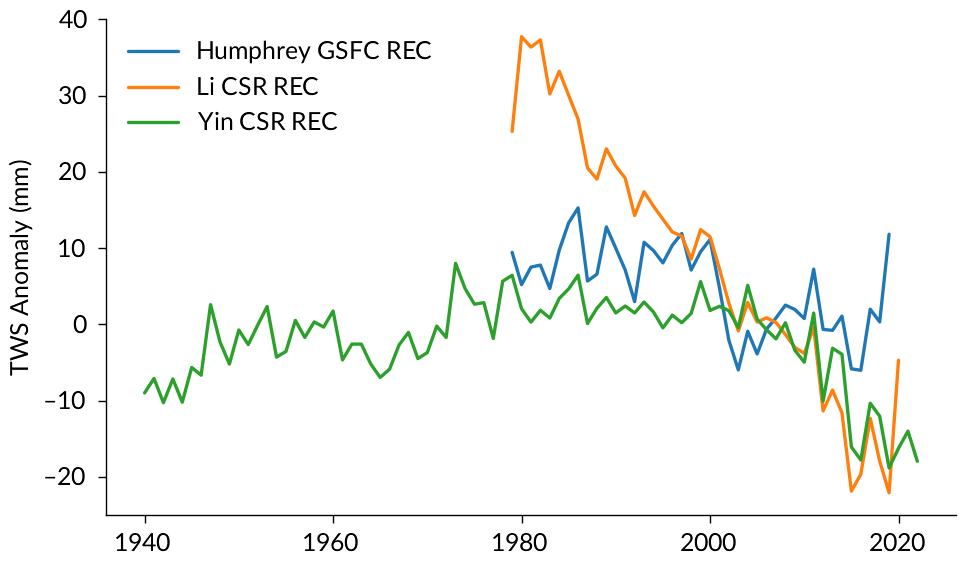

In [13]:
# Global average
recs_global = recs.where(mask == 1).dw.weight_lat().mean(["lat", "lon"]).chunk(time=-1)
humphrey = recs_global.humphrey_gsfc_detrend
li = recs_global.li_csr_full
yin = recs_global.yin_csr_full

humphrey_yearly = humphrey.groupby("time.year").mean()
li_yearly = li.groupby("time.year").mean()
yin_yearly = yin.groupby("time.year").mean()

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(humphrey_yearly.year, humphrey_yearly, label="Humphrey GSFC REC")
ax.plot(li_yearly.year, li_yearly, label="Li CSR REC")
ax.plot(yin_yearly.year, yin_yearly, label="Yin CSR REC")

ax.set(xlabel=None, ylabel="TWS Anomaly (mm)", ylim=(-25, 40))
ax.legend(loc="upper left")
fig.savefig(FIGURE_DIR / "recs_timeseries.pdf", backend="pgf")

## Input patches

In [14]:
inputs_verbose = {
    "cell_area": "Grid cell area",
    "nvec_x": "n-vector, X",
    "nvec_y": "n-vector, Y",
    "nvec_z": "n-vector, Z",
    "era5_tp": "Total precipitation",
    "era5_e": "Evaporation",
    "era5_pev": "Potential evap.",
    "era5_sp": "Surface pressure",
    "era5_sro": "Surface runoff",
    "era5_ssro": "Sub-surface runoff",
    "era5_t2m": "Temperature 2m",
    "era5_d2m": "Dewpoint temp 2m",
    "era5_lai_hv": "LAI, high",
    "era5_lai_lv": "LAI, low",
    "era5_cvh": "High veg cover",
    "era5_cvl": "Low veg cover",
    "era5_swvl1": "Soil water, lyr 1",
    "era5_swvl2": "Soil water, lyr 2",
    "era5_swvl3": "Soil water, lyr 3",
    "era5_swvl4": "Soil water, lyr 4",
    "cropland_rainfed": "Cropland, rainfed",
    "cropland_irrigated": "Cropland, irrigated",
    "pastures": "Pastures",
    "urbanareas": "Urban areas",
    "lakes": "Lake area",
    "twsa_gap": "WaterGAP TWSA",
    # "year_cos": "Annual, cosine",
    # "year_sin": "Annual, sine",
    # "year2_cos": "Semi-annual, cosine",
    # "year2_sin": "Semi-annual, sine",
    # "oni": "Oceanic Niño Index (ONI)",
}
print(f"{len(inputs_verbose) = }")


len(inputs_verbose) = 26


In [15]:
LAT_CENTER = -2.25
LON_CENTER = -55.25
# Half patch extension in degrees
PATCH_EXT = 8.5
# PATCH_EXT = 10
lat_slice = slice(LAT_CENTER + PATCH_EXT, LAT_CENTER - PATCH_EXT)
lon_slice = slice(LON_CENTER - PATCH_EXT, LON_CENTER + PATCH_EXT)
inputs = (
    inps[inputs_verbose.keys()]
    .sel(time="2020-06-01", lat=lat_slice, lon=lon_slice)
    .to_dataarray("feature")
)


In [16]:
ncols = 4
features = len(inputs_verbose)
nrows = int(np.ceil(features / ncols))


In [17]:
formatter = mpl.ticker.ScalarFormatter()
formatter.set_scientific(True)
cbar_kwargs = dict(
    location="right",
    aspect=10,
    shrink=0.8,
    format=formatter,
)
locator = mpl.ticker.MultipleLocator(10)


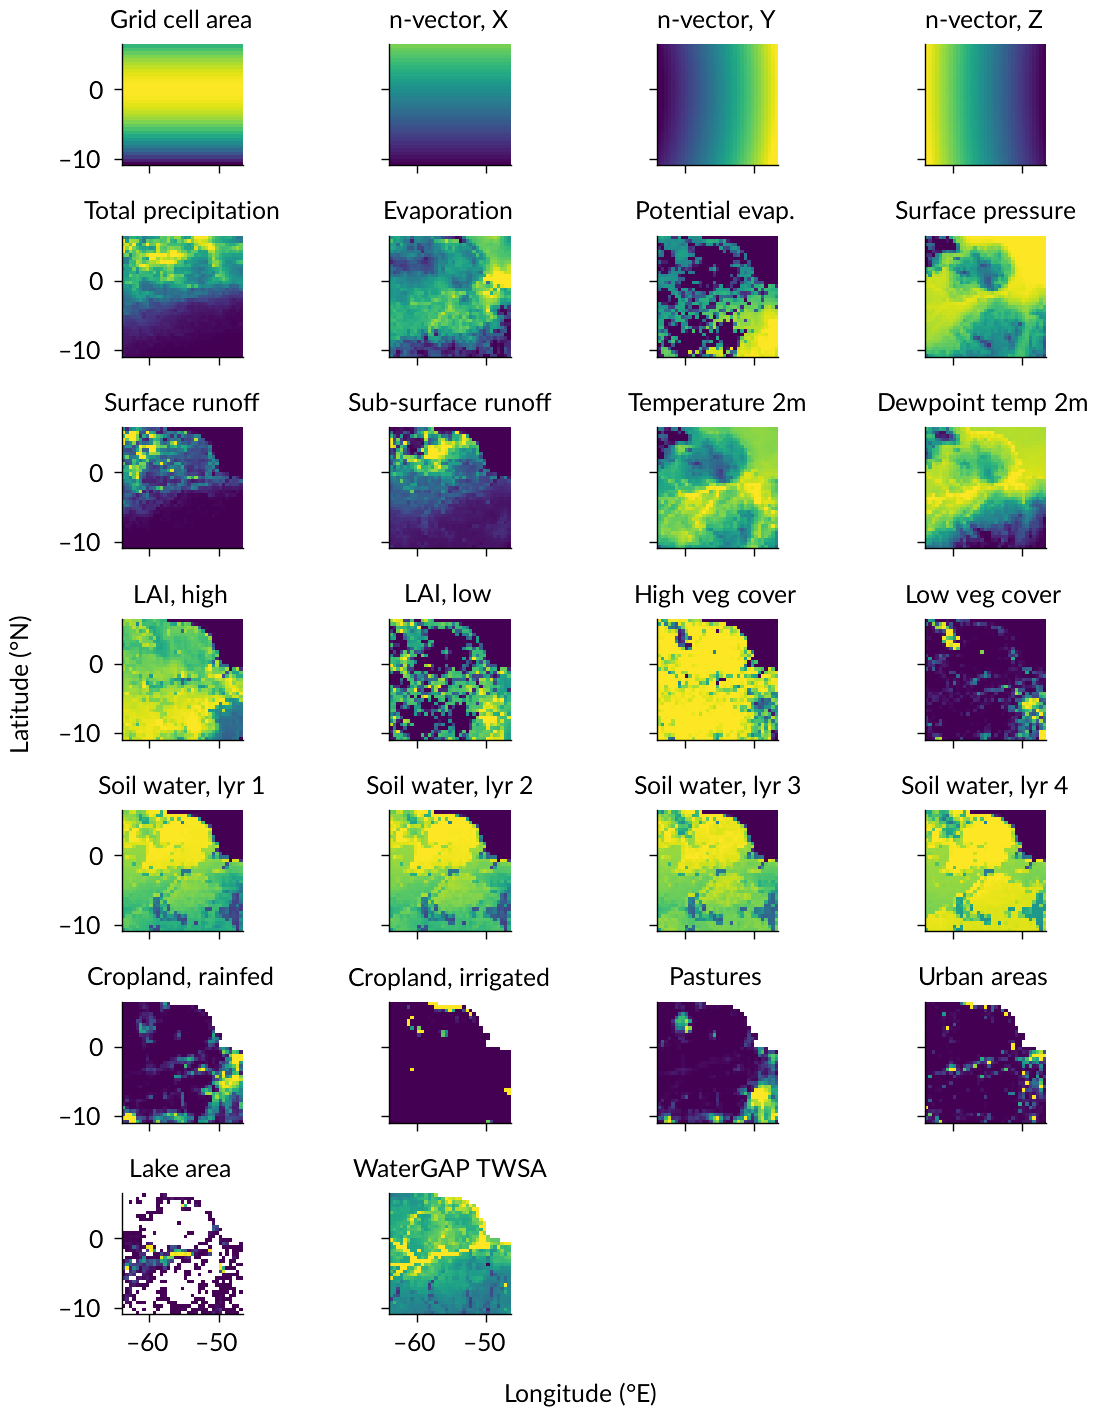

In [18]:
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5.5, 7))

for ax in axs.flat:
    ax.set_axis_off()

for i, (ax, feat) in enumerate(zip(axs.flat, inputs.feature.values)):
    if feat == "twsa_gap":
        vmin = -400
        vmax = 400
    elif feat.startswith("era5_swvl"):
        vmin = 0.0
        vmax = 0.5
    elif feat == "era5_pev":
        vmin = -0.006
        vmax = 0.00
    else:
        vmin = None
        vmax = None
    # Evaporation are defined negatively - reverse colormap
    cmap = "viridis_r" if feat == "era5_e" or feat == "era5_pev" else "viridis"

    ax.set_axis_on()
    data = inputs.sel(feature=feat)
    data.plot.pcolormesh(
        ax=ax,
        robust=True,
        vmin=vmin,
        vmax=vmax,
        cmap=cmap,
        add_colorbar=False,
        rasterized=True,
    )
    ax.set(
        title=inputs_verbose[feat],
        aspect="equal",
        xlabel=None,
        ylabel=None,
    )

    ax.yaxis.set_major_locator(locator)
    ax.label_outer()

# Set common labels
fig.text(0.5, 0, "Longitude (°E)", ha="center", va="top")
fig.text(0, 0.5, "Latitude (°N)", ha="right", va="center", rotation="vertical")

fig.savefig(FIGURE_DIR / "input_patches_test.pdf", backend="pgf")
